In [2]:
import tensorflow as tf
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import serial
import serial.tools.list_ports
import time

2022-04-21 14:43:20.004421: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-21 14:43:20.004439: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


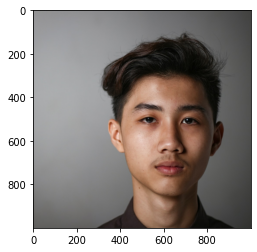

In [16]:
# LOAD IMAGE
img = Image.open('data/face.jpeg')
image = np.asarray(img)
original_h = image.shape[0]
original_w = image.shape[1]
image = image[:,int((original_w/2)-(original_h/2)):int((original_w/2)+(original_h/2)),:]
plt.imshow(image)

In [17]:
# MEDIAPIPE FACE DETECT INTERPRETER
interpreter = tf.lite.Interpreter(model_path="models/face_detection_front.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details[0])
print(output_details[0])
print(output_details[1])

{'name': 'input', 'index': 0, 'shape': array([  1, 128, 128,   3], dtype=int32), 'shape_signature': array([  1, 128, 128,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'regressors', 'index': 175, 'shape': array([  1, 896,  16], dtype=int32), 'shape_signature': array([  1, 896,  16], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'classificators', 'index': 174, 'shape': array([  1, 896,   1], dtype=int32), 'shape_signature': array([  1, 896,   1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': arr

In [18]:
def _ssd_generate_anchors() -> np.ndarray:
    """
    (reference: mediapipe/calculators/tflite/ssd_anchors_calculator.cc)
    """
    layer_id = 0
    num_layers = 4
    strides = [8, 16, 16, 16]
    assert len(strides) == num_layers
    input_height = 128
    input_width = 128
    anchor_offset_x = 0.5
    anchor_offset_y = 0.5
    interpolated_scale_aspect_ratio = 1
    anchors = []
    while layer_id < num_layers:
        last_same_stride_layer = layer_id
        repeats = 0
        while (last_same_stride_layer < num_layers and
               strides[last_same_stride_layer] == strides[layer_id]):
            last_same_stride_layer += 1
            # aspect_ratios are added twice per iteration
            repeats += 2 if interpolated_scale_aspect_ratio == 1.0 else 1
        stride = strides[layer_id]
        feature_map_height = input_height // stride
        feature_map_width = input_width // stride
        for y in range(feature_map_height):
            y_center = (y + anchor_offset_y) / feature_map_height
            for x in range(feature_map_width):
                x_center = (x + anchor_offset_x) / feature_map_width
                for _ in range(repeats):
                    anchors.append((x_center, y_center))
        layer_id = last_same_stride_layer
    return np.array(anchors, dtype=np.float32)
anchors = _ssd_generate_anchors()
print(anchors.shape)
with open("anchors.txt", 'w') as f:
    for i in range(anchors.shape[0]):
        if i % 8 == 0:
            f.write('\n')
        f.write(f'{anchors[i,0]:.5f},{anchors[i,1]:.5f},')
        

(896, 2)


[0.5686275 0.5686275 0.5764706]
[0.57254905 0.57254905 0.5803922 ]


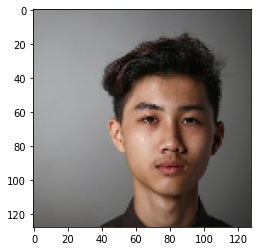

In [19]:
# FORMAT INPUT IMAGE
original_size = image.shape[0]
size = 128
resized_image = np.zeros([1,128,128,3],dtype='float32')
for x in range(0, size):  
    for y in range(0, size):
        srcX = int(round(float(x)/float(size)*float(original_size)))
        srcY = int(round(float(y)/float(size)*float(original_size)))
        srcX = min(srcX,original_size-1)
        srcY = min(srcY,original_size-1)
        pixel = image[srcX, srcY, :]
        resized_image[0,x,y,:] = pixel / 255
plt.imshow(np.reshape(resized_image, [128,128,3]))
print(resized_image[0,0,0,:])
print(np.reshape(tf.image.resize(image, [128,128]) / 255,[1,128,128,3])[0,0,0,:])
resized_image = np.reshape(tf.image.resize(image, [128,128]) / 255,[1,128,128,3])

In [20]:
# RUN FACE DETECT MODEL
interpreter.set_tensor(input_details[0]['index'], resized_image)
interpreter.invoke()
raw_boxes = interpreter.get_tensor(interpreter.get_output_details()[0]['index'])
raw_scores = interpreter.get_tensor(interpreter.get_output_details()[1]['index'])

In [21]:
# GET HIGHEST SCORE
raw_scores[raw_scores < -80] = -80
raw_scores[raw_scores > 80] = 80
best_index = 0
best_score = 0
for i in range(896):
    score = 1.0 / (1.0 + np.exp(-raw_scores[0,i,0]))
    if score > best_score:
        best_score = score
        best_index = i

In [22]:
# DECODE BOX
scale = 128
num_points = 8
# scale all values (applies to positions, width, and height alike)
face_box_center = raw_boxes[0, best_index, 0:2] / scale
face_box_wh = raw_boxes[0, best_index, 2:4] / scale
# adjust center coordinates to anchor positions
face_box_center += anchors[best_index]
# convert x_center, y_center, w, h to xmin, ymin, xmax, ymax
center = np.array(face_box_center)
half_size = face_box_wh / 2
[xmin, ymin] = center - half_size
[xmax, ymax] = center + half_size

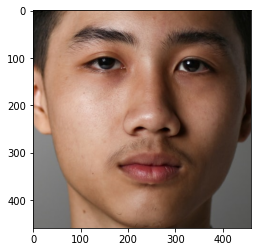

In [23]:
# EXTRACT FACE
face = image[int(ymin*original_size):int(ymax*original_size), int(xmin*original_size):int(xmax*original_size),:]
plt.imshow(face)

In [24]:
# MOBILENET INTERPRETER
interpreter = tf.lite.Interpreter(model_path="models/mobilenet_v1_0.25_192_quant.tflite")
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details[0])
print(output_details[0])

{'name': 'input', 'index': 88, 'shape': array([  1, 192, 192,   3], dtype=int32), 'shape_signature': array([  1, 192, 192,   3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.0078125, 128), 'quantization_parameters': {'scales': array([0.0078125], dtype=float32), 'zero_points': array([128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'MobilenetV1/Predictions/Reshape_1', 'index': 87, 'shape': array([   1, 1001], dtype=int32), 'shape_signature': array([   1, 1001], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.00390625, 0), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


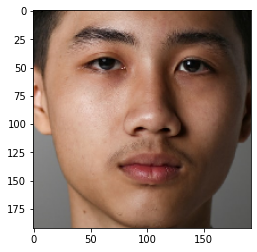

In [26]:
# FORMAT INPUT IMAGE
original_size = face.shape[0]
size = 192
resized_face = np.zeros([1,192,192,3],dtype='float32')
for x in range(0, size):  
    for y in range(0, size):
        srcX = int(round(float(x)/float(size)*float(original_size)))
        srcY = int(round(float(y)/float(size)*float(original_size)))
        srcX = min(srcX,original_size-1)
        srcY = min(srcY,original_size-1)
        pixel = face[srcX, srcY, :]
        resized_face[0,x,y,:] = pixel
plt.imshow(np.reshape(resized_face/255, [192,192,3]))
resized_face_uint8 = resized_face.astype('uint8')

In [27]:
# RUN MOBILENET MODEL
interpreter.set_tensor(input_details[0]['index'], resized_face_uint8)
interpreter.invoke()
logits = interpreter.get_tensor(output_details[0]['index'])
print(logits.nonzero()[1])
print(type(logits[0,0]))

[420 433 434 435 436 442 444 453 458 471 488 505 516 521 530 543 553 585
 586 611 618 623 630 642 653 668 679 680 681 684 698 715 720 723 762 786
 794 806 814 824 835 839 842 843 846 877 899 903 904 907 911 930 935 938
 949 967 969 972 999]
<class 'numpy.uint8'>
